# Comparing kernels

For the drug prediction task, there are many subjective choices needed regarding the choice of covariates to represent the cell lines and drugs, as well as the kernel choice itself.

For the RESCUER grant, we need to perform a comparison of some of these choices. As a basis I will look at the feature sets for the O'Neil dataset as collected by [Jeon et al. (2018)](https://github.com/mjjeon/dcpipe/)

## Available data

### Cell lines

#### Covariates

For the cell lines, we have multiple sets of covariates dealing with the molecular characteristics of the disease
   1. Gene expression (continuous)
   2. Mutations (binary)

These can be inserted into a standard GP kernel as is, but it might be further interesting to split the covariates into gene sets using pathway information (e.g. from [KEGG](https://www.genome.jp/kegg/pathway.html)), such that each set of covariates represent a meaningful biological pathways. In the Jeon dataset this has already been done, and we can use the genesets there directly. For example the p53 signalling geneset includes the genes TP53, MDM2, MDM4, CDKN2A, CDKN2B and TP53BP1.

We could then put a kernel function on each of the genesets, and sum them via e.g. a multiple-kernel-learning construction 
$$
K = \sum_{i} \alpha_iK_i,
$$
where each $K_i$ represent a base-kernel evaluated using only the covariates corresponding to the $i-th$ gene set.


#### Kernels
For the base-kernels, we will compare two very simple choices
- RBF: A standard, non-linear default choice
- RBF + ARD: Same as above, but with some feature selection built in.

   
   
### Drugs

#### Covariates
   
For the drugs, the covariates are given as SMILES formula, e.g.


| Drug | SMILES | 
| --- | --- |
| Erlotinib	 | COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC
| Metformin |CN(C)C(=N)N=C(N)N |
| Paclitaxel |  CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)C(C(C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C |


Which gives a unique representation of the drug's structure. From these it is common to compute various fingerprints to represent common structures in a binary string. There are many different fingerprints to choose from, and this is still an active research area. We use the Python library `gauche` to do all the pre-processing of chemical features. [Gauche](https://leojklarner.github.io/gauche/index.html) is an open-source library for molecular machine learning, with emphasis on Gaussian process regression and Bayesian optimization over molecules. It contains functions to pre-process SMILES into various types of fingerprints and kernel functions that work in a plug-and-play fashion with GPyTorch, which this library is built on top of.

While Gauche also allows the user to represent molecular as graphs, we will here only consider molecular fingerprints which has been the default choice in the community for the past 20 years. Gauche gives six options for fingerprints:
 - `ecfp_fingerprints`: Morgan fingerprints, returns a 2048 bit representation.
 - `fragments`:  Returns a vector of fragment counts based on standard molecular fragments, e.g. methoxy-groups, lactones and phenols.
 - `ecfp_fragprints`: A combination of the two above.


Since these fingerprints are high-dimensional, we further compute a PCA decomposition of the drugs to get a lower-dimensional representation. We select the number of components by a cutoff on explained variance. For this simple comparison we set this threshold to 75%.

#### Kernels
As for the kernels, we need to think about what a kernel over drug combinations should represent. Given some covariates for drug A, say $\mathbf{x}_A$, and some covariates for drug $B$, $\mathbf{x}_B$, we can represent the drug combination by simple concatenation $\mathbf{x}_{AB}=(\mathbf{x}_A, \mathbf{x}_B)$. We need to make sure that the kernel can capture the interaction between features of drug A and drug B, which potentially could correspond to interaction effects of the drugs. Because of this, we will consider 4 kernels:

- Linear kernel: No interaction
- Polynomial-2 kernel: Simple two-way interactions
- RBF Kernel: general non-linear kernel, all higher order interactions
- RBF Kernel + ARD: same as previous, but with some built-in feature selection.

## Comparing drug kernels

In this section, we will compare the performance of various kernels and fingerprint on predicting held-out drug in the ONeil dataset. We do this in a greedy fashion, where we first fix the fingerprint type, and optimize for the kernel, then using the optimal kernel we look at different options for the fingerprint.

For the comparison, we make some simplifying choices on the model structure to speed up training. We consider only 2000 inducing points, and make use of a mean field assumption on the inducing distribution -- this should ensure training is quick. Using the same settings across all the various drugs considered will still make everything comparable, even if it hasn't been evaluated at the maximum capacity.



In [1]:
import pandas as pd
import numpy as np
import gauche
from gauche.dataloader import MolPropLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
loader = MolPropLoader()
drugs = pd.read_csv("../synpred/data/ONeil_drug_SMILES.csv")
data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")

In [2]:
# Processing drug SMILES
loader.read_csv("../synpred/data/ONeil_drug_SMILES.csv",smiles_column="SMILES",label_column="Numeric",validate=True)
loader.featurize('ecfp_fingerprints')
X = loader.features
scaler = StandardScaler()
X = scaler.fit_transform(X)
pcacomponents = 21
pca = PCA(n_components=pcacomponents)
X = pca.fit_transform(X)
print("ratio variance explained: ",pca.explained_variance_ratio_.sum()) # Should be above 75%

# Merging onto the main dataframe
X = pd.DataFrame(X)
X = X.apply(zscore)
XA = X.add_prefix("A")
XB = X.add_prefix("B")
drugsA = pd.concat([drugs,XA],axis=1)
drugsA = drugsA.drop(columns=["Target","SMILES","Numeric"],axis=1)
drugsB = pd.concat([drugs,XB],axis=1)
drugsB = drugsB.drop(columns=["Target","SMILES","Numeric"],axis=1)
data = pd.merge(data,drugsA, left_on="DrugA",right_on="Name")
data = pd.merge(data,drugsB, left_on="DrugB",right_on="Name")
data = data.drop(columns=["Name_x","Name_y"])

ratio variance explained:  0.7501083397015198


In [3]:
# Sort the data, and pull out a single cell line
data = data.sort_values(["CellLine","DrugA","DrugB"])
k = 1*583*100
data = data.head(k)
print(data["CellLine"].unique()) # Should be a single value here

['A2058']


In [4]:
# Now splitting the dataset into a test and train set
from sklearn.model_selection import train_test_split
k = np.floor(583*0.8)
data["combination"] = data.DrugA.map(str) + "_" + data.DrugB
train_combinations, test_combinations = train_test_split(pd.DataFrame(data.combination.unique()), test_size=0.2)
train = data[data["combination"].isin(train_combinations[0].tolist())]
test = data[data["combination"].isin(test_combinations[0].tolist())]
# Now drop the combination column
train = train.drop(columns=["combination"])
test = test.drop(columns=["combination"])

In [5]:
# Now setting up the actual datasets
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
y_train = torch.tensor(train["fMean"].values).float()
y_test = torch.tensor(test["fMean"].values).float()
conc_train = train[['DrugAconc','DrugBconc']]
conc_test = test[['DrugAconc','DrugBconc']]
drugcovars_train = train.iloc[:,-(pcacomponents*2):]
drugcovars_test = test.iloc[:,-(pcacomponents*2):]
X_train = torch.tensor(pd.concat([conc_train,drugcovars_train],axis=1).values).float()
X_test = torch.tensor(pd.concat([conc_test,drugcovars_test],axis=1).values).float()

In [6]:
# Setting up minibatching
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [11]:
# Setting up the models
from synpred.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy


### Model 1 -- Linear kernel
class DrugCombModel1(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace((2+pcacomponents),1+(2*pcacomponents),pcacomponents),torch.linspace(2,1+pcacomponents,pcacomponents)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train.size(0))
        inducing_points = torch.stack([X_train[ind_indices[:2000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel1,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
        # Covar over the drugs, Linear
        self.covar_module_drugs = gpytorch.kernels.LinearKernel(active_dims=torch.linspace(2,2*pcacomponents+1,2*pcacomponents).long()
                                                            )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Model 2 -- Polynomial kernel
class DrugCombModel2(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace((2+pcacomponents),1+(2*pcacomponents),pcacomponents),torch.linspace(2,1+pcacomponents,pcacomponents)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train.size(0))
        inducing_points = torch.stack([X_train[ind_indices[:2000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel2,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
        # Covar over the drugs, Polynomial (note the scale kernel in front to compete with linear)
        self.covar_module_drugs = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(active_dims=torch.linspace(2,2*pcacomponents+1,2*pcacomponents).long(),
                                                            power=2))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Model 3 -- RBF
class DrugCombModel3(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace((2+pcacomponents),1+(2*pcacomponents),pcacomponents),torch.linspace(2,1+pcacomponents,pcacomponents)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train.size(0))
        inducing_points = torch.stack([X_train[ind_indices[:2000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel3,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
        # Covar over the drugs, RBF 
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,2*pcacomponents+1,2*pcacomponents).long(),
                                                            ard_num_dims=None)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Model 4 -- RBF + ARD
class DrugCombModel4(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace((2+pcacomponents),1+(2*pcacomponents),pcacomponents),torch.linspace(2,1+pcacomponents,pcacomponents)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train.size(0))
        inducing_points = torch.stack([X_train[ind_indices[:2000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel4,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
        # Covar over the drugs, RBF + ARD
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,2*pcacomponents+1,2*pcacomponents).long(),
                                                            ard_num_dims=2*pcacomponents)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


    
model1 = DrugCombModel1()
model2 = DrugCombModel2()
model3 = DrugCombModel3()
model4 = DrugCombModel4()
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
likelihood3 = gpytorch.likelihoods.GaussianLikelihood()
likelihood4 = gpytorch.likelihoods.GaussianLikelihood()

In [12]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
from torch.optim.lr_scheduler import MultiStepLR
num_epochs = 20 # Number of complete passes through the data

# Will train all models in the same loop

model1.train()
model2.train()
model3.train()
model4.train()

likelihood1.train()
likelihood2.train()
likelihood3.train()
likelihood4.train()

hyperparameter_optimizer1 = torch.optim.Adam([
    {'params': model1.parameters()},
    {'params': likelihood1.parameters()},
], lr=0.01)

hyperparameter_optimizer2 = torch.optim.Adam([
    {'params': model2.parameters()},
    {'params': likelihood2.parameters()},
], lr=0.01)

hyperparameter_optimizer3 = torch.optim.Adam([
    {'params': model3.parameters()},
    {'params': likelihood3.parameters()},
], lr=0.01)

hyperparameter_optimizer4 = torch.optim.Adam([
    {'params': model4.parameters()},
    {'params': likelihood4.parameters()},
], lr=0.01)

scheduler_hypers1 = MultiStepLR(hyperparameter_optimizer1, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)
scheduler_hypers2 = MultiStepLR(hyperparameter_optimizer2, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)
scheduler_hypers3 = MultiStepLR(hyperparameter_optimizer3, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)
scheduler_hypers4 = MultiStepLR(hyperparameter_optimizer4, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)

# Tracking loss
train_loss1 = []
train_loss2 = []
train_loss3 = []
train_loss4 = []


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll1 = gpytorch.mlls.VariationalELBO(likelihood1, model1, num_data=y_train.size(0))
mll2 = gpytorch.mlls.VariationalELBO(likelihood2, model2, num_data=y_train.size(0))
mll3 = gpytorch.mlls.VariationalELBO(likelihood3, model3, num_data=y_train.size(0))
mll4 = gpytorch.mlls.VariationalELBO(likelihood4, model4, num_data=y_train.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
with gpytorch.settings.cholesky_max_tries(12):
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer1.zero_grad()
            hyperparameter_optimizer2.zero_grad()
            hyperparameter_optimizer3.zero_grad()
            hyperparameter_optimizer4.zero_grad()
            # Get outputs
            output1 = model1(x_batch)
            output2 = model2(x_batch)
            output3 = model3(x_batch)
            output4 = model4(x_batch)
            # Compute loss
            loss1 = -mll1(output1, y_batch)
            loss2 = -mll2(output2, y_batch)
            loss3 = -mll3(output3, y_batch)
            loss4 = -mll4(output4, y_batch)
            # Call backward on loss
            loss1.backward()
            loss2.backward()
            loss3.backward()
            loss4.backward()
            # Take a step
            hyperparameter_optimizer1.step()
            hyperparameter_optimizer2.step()
            hyperparameter_optimizer3.step()
            hyperparameter_optimizer4.step()
            
            
            # Update counter
            minibatch_iter.set_postfix(loss1=loss1.item(),loss2=loss2.item(),loss3=loss3.item(),loss4=loss4.item())
            
            # Track loss
            train_loss1.append(loss1.item())
            train_loss2.append(loss2.item())
            train_loss3.append(loss3.item())
            train_loss4.append(loss4.item())
            
            
        # Step learning rate scheduler
        scheduler_hypers1.step()
        scheduler_hypers2.step()
        scheduler_hypers3.step()
        scheduler_hypers4.step()
        

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

In [31]:
torch.tensor(train_loss1).add(2).log()

tensor([3.8405, 3.8257, 3.8307,  ..., 1.1177, 1.1068, 1.1238])

(0.0, 2.0)

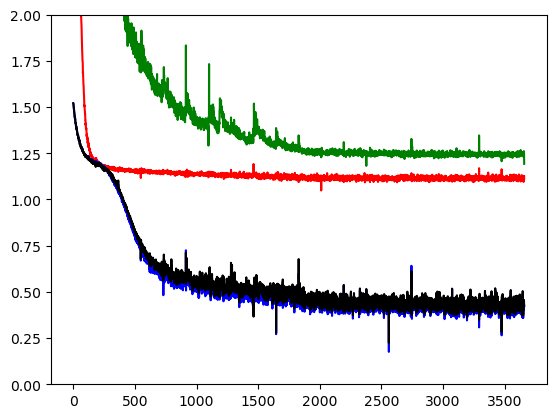

In [33]:
plt.plot(torch.tensor(train_loss1).add(2).log(), "r-")
plt.plot(torch.tensor(train_loss2).add(2).log(), "g-")
plt.plot(torch.tensor(train_loss3).add(2).log(), "b-")
plt.plot(torch.tensor(train_loss4).add(2).log(), "k-")
plt.ylim(0,2)

A bit surprisingly, the ARD doesn't really seem to add anything to the training loss. Let's look at the estimated length scales

In [42]:
print(model3.covar_module_drugs.lengthscale)
print(model4.covar_module_drugs.lengthscale)


tensor([[12.3305]], grad_fn=<SoftplusBackward0>)
tensor([[ 5.8889,  4.7842, 10.0429,  8.0754, 10.1906, 10.9788, 12.0735, 13.0079,
          8.3037, 13.1443, 12.9936, 10.5663, 13.3086, 11.2628,  6.3035, 11.4812,
         11.6451, 11.9316, 11.7899,  7.9586,  9.7358,  5.0514, 11.5923, 12.6928,
         12.9546, 13.0178, 12.9068, 12.4038, 12.7344, 10.4758, 11.9879, 11.7615,
         12.9282, 13.4207, 12.3537,  9.9625, 12.3202, 11.8664, 12.5043, 11.0829,
         10.3932, 11.9920]], grad_fn=<SoftplusBackward0>)


It could be the case that with PCA factors as input, the ARD doesn't really matter as much. The PCA factors are aswell quite uniform in importance. It is not the case that a large proportion of the variance is explained by a couple of factors.

Now let's look at prediction performance

In [34]:
# Set into eval mode
model1.eval()
model2.eval()
model3.eval()
model4.eval()
likelihood1.eval()
likelihood2.eval()
likelihood3.eval()
likelihood4.eval()
# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions1 = likelihood1(model1(X_test))
    predictions2 = likelihood2(model2(X_test))
    predictions3 = likelihood3(model3(X_test))
    predictions4 = likelihood4(model4(X_test))
    mean1 = predictions1.mean
    mean2 = predictions2.mean
    mean3 = predictions3.mean
    mean4 = predictions4.mean
    #lower, upper = predictions.confidence_region()



In [40]:
print(np.corrcoef(mean1.squeeze(0),y_test))
print(np.corrcoef(mean2.squeeze(0),y_test))
print(np.corrcoef(mean3.squeeze(0),y_test))
print(np.corrcoef(mean4.squeeze(0),y_test))

[[1.         0.42255009]
 [0.42255009 1.        ]]
[[1.         0.80361184]
 [0.80361184 1.        ]]
[[1.         0.91178236]
 [0.91178236 1.        ]]
[[1.         0.90534793]
 [0.90534793 1.        ]]


We see that model 1 (linear) does the worst in terms of predition performance, likely because it is not able to model the interaction between drugs. The polynomial kernel does a bit better, but the RBF is the best overall (with standard RBF slightly beating the RBF + ARD even). Moving forward, I'll work with the standard RBF kernel.

Now let's look at the various fingerprint options. Above we used the standard Morgan fingerprint, but we could also look at some variations here.

In [63]:
import pandas as pd
import numpy as np
import gauche
from gauche.dataloader import MolPropLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
loader = MolPropLoader()
drugs = pd.read_csv("../synpred/data/ONeil_drug_SMILES.csv")
data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")
# Processing drug SMILES
loader.read_csv("../synpred/data/ONeil_drug_SMILES.csv",smiles_column="SMILES",label_column="Numeric",validate=True)


########################################
########## fragments ###################
########################################
loader.featurize('fragments')
X = loader.features
scaler = StandardScaler()
X = scaler.fit_transform(X)
pcacomponents_fragments = 12 # 12 for fragments
pca = PCA(n_components=pcacomponents_fragments)
X = pca.fit_transform(X)
print("ratio variance explained: ",pca.explained_variance_ratio_.sum()) # Should be above 75%

# Merging onto the main dataframe
X = pd.DataFrame(X)
X = X.apply(zscore)
XA = X.add_prefix("A_fragments")
XB = X.add_prefix("B_fragments")
drugsA = pd.concat([drugs,XA],axis=1)
drugsA = drugsA.drop(columns=["Target","SMILES","Numeric"],axis=1)
drugsB = pd.concat([drugs,XB],axis=1)
drugsB = drugsB.drop(columns=["Target","SMILES","Numeric"],axis=1)


data = pd.merge(data,drugsA, left_on="DrugA",right_on="Name")
data = pd.merge(data,drugsB, left_on="DrugB",right_on="Name")
data = data.drop(columns=["Name_x","Name_y"])


########################################
########## fragprints ##################
########################################
#data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")
loader.read_csv("../synpred/data/ONeil_drug_SMILES.csv",smiles_column="SMILES",label_column="Numeric",validate=True)
loader.featurize('ecfp_fragprints')
X = loader.features
scaler = StandardScaler()
X = scaler.fit_transform(X)
pcacomponents_fragprints = 21 # 21 for fragprints
pca = PCA(n_components=pcacomponents_fragprints)
X = pca.fit_transform(X)
print("ratio variance explained: ",pca.explained_variance_ratio_.sum()) # Should be above 75%#

# Merging onto the main dataframe
X = pd.DataFrame(X)
X = X.apply(zscore)
XA = X.add_prefix("A_fragprints")
XB = X.add_prefix("B_fragprints")
drugsA = pd.concat([drugs,XA],axis=1)
drugsA = drugsA.drop(columns=["Target","SMILES","Numeric"],axis=1)
drugsB = pd.concat([drugs,XB],axis=1)
drugsB = drugsB.drop(columns=["Target","SMILES","Numeric"],axis=1)


data = pd.merge(data,drugsA, left_on="DrugA",right_on="Name")
data = pd.merge(data,drugsB, left_on="DrugB",right_on="Name")
data = data.drop(columns=["Name_x","Name_y"])

ratio variance explained:  0.7654594221238501
ratio variance explained:  0.7494591972689711


In [65]:
# Sort the data, and pull out a single cell line
data = data.sort_values(["CellLine","DrugA","DrugB"])
k = 1*583*100
data = data.head(k)
print(data["CellLine"].unique()) # Should be a single value here

['A2058']


In [66]:
# Now splitting the dataset into a test and train set
from sklearn.model_selection import train_test_split
k = np.floor(583*0.8)
data["combination"] = data.DrugA.map(str) + "_" + data.DrugB
train_combinations, test_combinations = train_test_split(pd.DataFrame(data.combination.unique()), test_size=0.2)
train = data[data["combination"].isin(train_combinations[0].tolist())]
test = data[data["combination"].isin(test_combinations[0].tolist())]
# Now drop the combination column
train = train.drop(columns=["combination"])
test = test.drop(columns=["combination"])

In [75]:
[col for col in train if col.startswith("fragments",2,len(col))]

['A_fragments0',
 'A_fragments1',
 'A_fragments2',
 'A_fragments3',
 'A_fragments4',
 'A_fragments5',
 'A_fragments6',
 'A_fragments7',
 'A_fragments8',
 'A_fragments9',
 'A_fragments10',
 'A_fragments11',
 'B_fragments0',
 'B_fragments1',
 'B_fragments2',
 'B_fragments3',
 'B_fragments4',
 'B_fragments5',
 'B_fragments6',
 'B_fragments7',
 'B_fragments8',
 'B_fragments9',
 'B_fragments10',
 'B_fragments11']

In [74]:
[col for col in train]
    print(col.startswith("fragments",2,len(col)))

['CellLine',
 'DrugA',
 'DrugB',
 'DrugAconc',
 'DrugBconc',
 'GPMean',
 'GPVar',
 'fMean',
 'fVAR',
 'p0Mean',
 'b1',
 'b2',
 'A_fragments0',
 'A_fragments1',
 'A_fragments2',
 'A_fragments3',
 'A_fragments4',
 'A_fragments5',
 'A_fragments6',
 'A_fragments7',
 'A_fragments8',
 'A_fragments9',
 'A_fragments10',
 'A_fragments11',
 'B_fragments0',
 'B_fragments1',
 'B_fragments2',
 'B_fragments3',
 'B_fragments4',
 'B_fragments5',
 'B_fragments6',
 'B_fragments7',
 'B_fragments8',
 'B_fragments9',
 'B_fragments10',
 'B_fragments11',
 'A_fragprints0',
 'A_fragprints1',
 'A_fragprints2',
 'A_fragprints3',
 'A_fragprints4',
 'A_fragprints5',
 'A_fragprints6',
 'A_fragprints7',
 'A_fragprints8',
 'A_fragprints9',
 'A_fragprints10',
 'A_fragprints11',
 'A_fragprints12',
 'A_fragprints13',
 'A_fragprints14',
 'A_fragprints15',
 'A_fragprints16',
 'A_fragprints17',
 'A_fragprints18',
 'A_fragprints19',
 'A_fragprints20',
 'B_fragprints0',
 'B_fragprints1',
 'B_fragprints2',
 'B_fragprints3',
 

In [78]:
# Now setting up the actual datasets
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
y_train = torch.tensor(train["fMean"].values).float()
y_test = torch.tensor(test["fMean"].values).float()
conc_train = train[['DrugAconc','DrugBconc']]
conc_test = test[['DrugAconc','DrugBconc']]
fragmentcol = [col for col in train if col.startswith("fragments",2,len(col))]
fragprintcol = [col for col in train if col.startswith("fragprint",2,len(col))]
drugcovars_train_fragments = train[fragmentcol]
drugcovars_test_fragments = test[fragmentcol]
drugcovars_train_fragprints = train[fragprintcol]
drugcovars_test_fragprints = test[fragprintcol]
X_train_fragments = torch.tensor(pd.concat([conc_train,drugcovars_train_fragments],axis=1).values).float()
X_test_fragments = torch.tensor(pd.concat([conc_test,drugcovars_test_fragments],axis=1).values).float()
X_train_fragprints = torch.tensor(pd.concat([conc_train,drugcovars_train_fragprints],axis=1).values).float()
X_test_fragprints = torch.tensor(pd.concat([conc_test,drugcovars_test_fragprints],axis=1).values).float()

In [86]:
# Setting up minibatching
from torch.utils.data import TensorDataset, DataLoader
train_dataset_fragments = TensorDataset(X_train_fragments, y_train)
train_loader_fragments = DataLoader(train_dataset_fragments, batch_size=256, shuffle=True)
train_dataset_fragprints = TensorDataset(X_train_fragprints, y_train)
train_loader_fragprints = DataLoader(train_dataset_fragprints, batch_size=256, shuffle=True)

In [85]:
### Fragments
class DrugCombModel3_fragments(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace((2+pcacomponents_fragments),1+(2*pcacomponents_fragments),pcacomponents_fragments),torch.linspace(2,1+pcacomponents_fragments,pcacomponents_fragments)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train_fragments.size(0))
        inducing_points = torch.stack([X_train_fragments[ind_indices[:2000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel3_fragments,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
        # Covar over the drugs, RBF 
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,2*pcacomponents_fragments+1,2*pcacomponents_fragments).long(),
                                                            ard_num_dims=None)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
### Fragprints
class DrugCombModel3_fragprints(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace((2+pcacomponents_fragprints),1+(2*pcacomponents_fragprints),pcacomponents_fragprints),torch.linspace(2,1+pcacomponents_fragprints,pcacomponents_fragprints)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train_fragprints.size(0))
        inducing_points = torch.stack([X_train_fragprints[ind_indices[:2000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel3_fragprints,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
        # Covar over the drugs, RBF 
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,2*pcacomponents_fragprints+1,2*pcacomponents_fragprints).long(),
                                                            ard_num_dims=None)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
model_fragments = DrugCombModel3_fragments()
model_fragprints = DrugCombModel3_fragprints()
likelihood_fragments = gpytorch.likelihoods.GaussianLikelihood()
likelihood_fragprints = gpytorch.likelihoods.GaussianLikelihood()


In [87]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
from torch.optim.lr_scheduler import MultiStepLR
num_epochs = 20 # Number of complete passes through the data

# Will train all models in the same loop

model_fragments.train()
model_fragprints.train()

likelihood_fragments.train()
likelihood_fragprints.train()

hyperparameter_optimizer_fragments = torch.optim.Adam([
    {'params': model_fragments.parameters()},
    {'params': likelihood_fragments.parameters()},
], lr=0.01)

hyperparameter_optimizer_fragprints = torch.optim.Adam([
    {'params': model_fragprints.parameters()},
    {'params': likelihood_fragprints.parameters()},
], lr=0.01)

scheduler_hypers_fragments = MultiStepLR(hyperparameter_optimizer_fragments, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)
scheduler_hypers_fragprints = MultiStepLR(hyperparameter_optimizer_fragprints, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)

# Tracking loss
train_loss_fragments = []
train_loss_fragprints = []


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll_fragments = gpytorch.mlls.VariationalELBO(likelihood_fragments, model_fragments, num_data=y_train.size(0))
mll_fragprints = gpytorch.mlls.VariationalELBO(likelihood_fragprints, model_fragprints, num_data=y_train.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
with gpytorch.settings.cholesky_max_tries(12):
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        # Fragments
        minibatch_iter = tqdm.notebook.tqdm(train_loader_fragments, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer_fragments.zero_grad()
            # Get outputs
            output_fragments = model_fragments(x_batch)
            # Compute loss
            loss_fragments = -mll_fragments(output_fragments, y_batch)
            # Call backward on loss
            loss_fragments.backward()
            # Take a step
            hyperparameter_optimizer_fragments.step()
              
            # Update counter
            minibatch_iter.set_postfix(loss_fragments=loss_fragments.item())
            
            # Track loss
            train_loss_fragments.append(loss_fragments.item())
            
        # Fragprints
        minibatch_iter = tqdm.notebook.tqdm(train_loader_fragprints, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer_fragprints.zero_grad()
            # Get outputs
            output_fragprints = model_fragprints(x_batch)
            # Compute loss
            loss_fragprints = -mll_fragprints(output_fragprints, y_batch)
            # Call backward on loss
            loss_fragprints.backward()
            # Take a step
            hyperparameter_optimizer_fragprints.step()
              
            # Update counter
            minibatch_iter.set_postfix(loss_fragments=loss_fragments.item(), loss_fragprints=loss_fragprints.item(), )
            
            # Track loss
            train_loss_fragprints.append(loss_fragprints.item())
        
            
            
        # Step learning rate scheduler
        scheduler_hypers_fragments.step()
        scheduler_hypers_fragprints.step()

        

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

(0.0, 2.0)

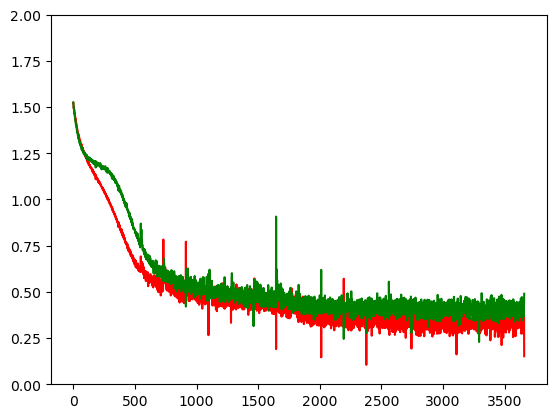

In [90]:
plt.plot(torch.tensor(train_loss_fragments).add(2).log(), "r-")
plt.plot(torch.tensor(train_loss_fragprints).add(2).log(), "g-")
plt.plot()
plt.ylim(0,2)

Training loss is lower for fragments only compared to the combined fragprints. Let's look at the prediction error

In [92]:
# Set into eval mode
model_fragments.eval()
model_fragprints.eval()
likelihood_fragments.eval()
likelihood_fragprints.eval()

# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_fragments = likelihood_fragments(model_fragments(X_test_fragments))
    predictions_fragprints = likelihood_fragprints(model_fragprints(X_test_fragprints))
    mean_fragments = predictions_fragments.mean
    mean_fragprints = predictions_fragprints.mean


In [95]:
print(np.corrcoef(mean_fragments.squeeze(0),y_test))
print(np.corrcoef(mean_fragprints.squeeze(0),y_test))
print(np.corrcoef(torch.tensor(test["p0Mean"].values).float(),y_test)) # Not yet at level of p0.

[[1.         0.93664612]
 [0.93664612 1.        ]]
[[1.         0.91882836]
 [0.91882836 1.        ]]
[[1.       0.978118]
 [0.978118 1.      ]]


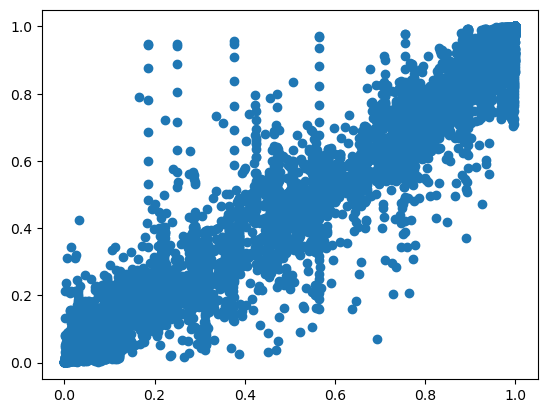

In [97]:
plt.scatter(torch.tensor(test["p0Mean"].values).float(),y_test)

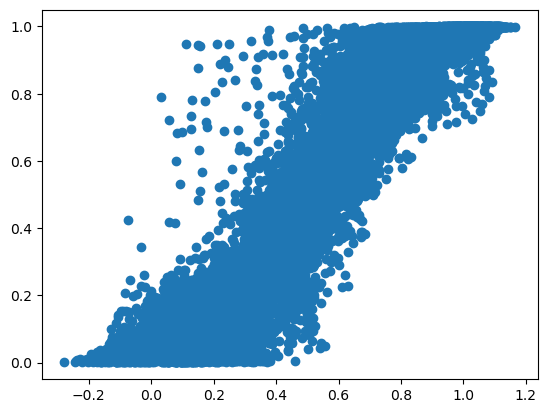

In [98]:
plt.scatter(mean_fragments.squeeze(0),y_test)

Here as well we see that fragments do a better job. So to summarise, the drug covariance is best specified using a standard RBF kernel, with the fragments representation of the SMILES formula.

## Comparing cell line kernels

Now moving on to the cell line representation. We already know we want to pursue some sort of MKL framework here, which should be easy to do within `gpytorch`. Again, will consider a simple case where we fix a single drug combination, and consider predicting the dose-response curve at a held-out cell line. 

Regarding number of inducing points, as there are no drug covariates we are simply left with predicting a surface over the unit box $[0,1] \times [0,1]$, and hence can get away with as little as 100 inducing points in total -- which should make training fast. For the variational distribution I use a Cholesky variant which will give some more flexibility for little extra cost.

In terms of comparing various kernels, the thing I'm most curious about is if utilizing pathway information gives any added benefit.

Let's start of with a very simple multi-task model, e.g. an ICM model, where each output is a cell line. In order to keep computational complexity low we will assume that our 39 cell lines share 10 latent functions. The covariance function over the cell lines are assumed to be a multiple-kernel-learning style covariance which I need to code up below.

There are three main things to check here
- for non-continuous features, does an RBF make sense over e.g. a linear kernel?
- does ARD have any effect?
- does splitting data into pathways make a difference?

In [221]:
# Start by reading in the data again
import pandas as pd
import numpy as np
from scipy.stats import zscore
data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")

In [222]:
# Reading in the datasets
from scipy.stats import zscore

# Mutations
mutations = pd.read_csv("/Users/leiv/Documents/PhD/Data/ONeil_formatted_Jeon/dcpipe-master 2/Data/featureFolder/mutation/Merck_mutations_merckclname.csv")
mutations = mutations[["SAMPLE","GENE","CLASSIFICATION"]]
mutations = mutations.sort_values(["SAMPLE","GENE","CLASSIFICATION"])
mutations = mutations.groupby(["SAMPLE","GENE"]).last()["CLASSIFICATION"].reset_index()
mutations["CLASSIFICATION"] = 1
mutations = mutations.pivot(index="SAMPLE",columns="GENE",values="CLASSIFICATION").fillna(0)

# Gene expression
gex = pd.read_csv("/Users/leiv/Documents/PhD/Data/ONeil_formatted_Jeon/dcpipe-master 2/Data/featureFolder/gex/Merck_expression_matrix.csv")
gex = gex.sort_values(["CELLLINE"])
gex.update(gex.drop(columns=["CELLLINE"]).apply(zscore))

# Find common cell lines
common = list(set(gex.CELLLINE.unique()).intersection(set(mutations.index.values)))
mutations = mutations.loc[common]
gex = gex[gex["CELLLINE"].isin(common)]

# Only keep data where we have the omics
data = data[data["CellLine"].isin(common)]

In [228]:
# Pull out a single combination of interest, AZD1775_MK-8669 which is synergistic
data["combination"] = data.DrugA.map(str) + "_" + data.DrugB
data = data[data["combination"].isin(["AZD1775_MK-8669"])]
data = data.drop(columns=["combination"])
data["task_index"] = pd.Categorical(data['CellLine']).codes
# Split by cell line
from sklearn.model_selection import train_test_split
train_cells, test_cells = train_test_split(pd.DataFrame(data.CellLine.unique()), test_size = 0.2)
train = data[data["CellLine"].isin(train_cells[0].tolist())]
test = data[data["CellLine"].isin(test_cells[0].tolist())]



In [259]:
# Now setting up the actual datasets
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
y_train = torch.tensor(train["fMean"].values).float()
y_test = torch.tensor(test["fMean"].values).float()
conc_train = train[['DrugAconc','DrugBconc']]
conc_test = test[['DrugAconc','DrugBconc']]
X_train = torch.tensor(pd.concat([conc_train],axis=1).values).float()
X_test = torch.tensor(pd.concat([conc_test],axis=1).values).float()
train_indices = torch.tensor(train["task_index"].values).long()
test_indices = torch.tensor(test["task_index"].values).long()
num_tasks = data.task_index.max() + 1
num_latents = 10

In [261]:
# Reshaping these as torch tensors
gex = torch.tensor(gex.drop(columns=["CELLLINE"]).values)
mutations = torch.tensor(mutations.values)

In [308]:
# Setting up minibatching
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train, train_indices)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)

Now setting up the model

In [405]:
from synpred.variational.outputcovariance_lmc_variational_strategy import OutputCovarianceLMCVariationalStrategy

class ICM(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        inducing_points = torch.rand(num_latents,40,2)
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )
        
        # Covariance over the outputs, and initialized by covariates
        output_kernel = gpytorch.kernels.RBFKernel()
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = OutputCovarianceLMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, 
                learn_inducing_locations=True
            ),
            output_kernel,
            output_covars,
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super(ICM,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
model = ICM(gex)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [411]:
latent_dist = model.variational_strategy.base_variational_strategy(x_batch)
num_batch = len(latent_dist.batch_shape)
latent_dim = num_batch + -1

In [412]:
lmc_coefficients = _select_lmc_coefficients(self.lmc_coefficients, task_indices)

0

In [398]:
model.variational_strategy.output_kernel.lengthscale

tensor([[0.6931]], grad_fn=<SoftplusBackward0>)

In [404]:
model.variational_strategy(x_batch)

MultitaskMultivariateNormal(mean shape: torch.Size([24, 30]))

In [390]:
model.train()
likelihood.train()
hyperparameter_optimizer.zero_grad()
output = model(x_batch,task_indices=task_batch)
#loss = -mll(output, y_batch)
            

NanError: cholesky_cpu: 16000 of 16000 elements of the torch.Size([10, 40, 40]) tensor are NaN.

In [387]:
output

MultivariateNormal(loc: torch.Size([24]))

In [388]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
num_epochs = 20 # Number of complete passes through the data


model.train()
likelihood.train()



hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)



# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
with gpytorch.settings.cholesky_max_tries(12):
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch, task_batch in minibatch_iter:
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch,task_indices=task_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            hyperparameter_optimizer.step()
        

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/100 [00:00<?, ?it/s]

NanError: cholesky_cpu: 16000 of 16000 elements of the torch.Size([10, 40, 40]) tensor are NaN.